<a href="https://colab.research.google.com/github/abhijithgithub23/Portfolio-rizaan-a/blob/master/Sepsis_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import glob
import os
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from __future__ import print_function
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.cluster import homogeneity_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.cm as cm
%matplotlib inline

In [ ]:
! pip install fancyimpute

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 7.4 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29879 sha256=8df4aa609dbceac404a45c9a1a5e3e05ffeacc1e7d5cc0431b67210a57dd1c21
  Stored in directory: /root/.cache/pip/wheels/7b/0c/d3/ee82d1fbdcc0858d96434af108608d01703505d453720c84ed
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11329 sha256=fb58d21961199c41578a13bbedb1faedbc593f2c9c4412277e13a87b64f74106
  Stored in directory: /root/.cache/pip/wheels/46/06/a5/45a724630562413c374e29c08732411d496092408b3a7bf754
Successfully built fancyimpute knnimpute


In [ ]:
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, BiScaler, IterativeImputer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Retained features:
['HR' 'O2Sat' 'SBP' 'MAP' 'DBP' 'Resp' 'Hour' 'Age' 'Gender' 'Unit1'
 'Unit2' 'HospAdmTime' 'ICULOS' 'Identifier' 'SepsisLabel']
      HR      O2Sat         SBP   MAP        DBP  Resp  Hour    Age  Gender     Unit1     Unit2  HospAdmTime  ICULOS  SepsisLabel     Identifier
0  106.0  95.000000  112.000000  62.0  44.000000  14.0   0.0  81.14     1.0  0.536244  0.463756       -19.47    56.0          1.0  balanced_data
1   84.0  99.000000   69.500000  42.0  39.000000  14.0   1.0  60.52     0.0  0.536244  0.463756      -183.61    16.0          1.0  balanced_data
2   71.0  97.000000  155.000000  93.0  69.000000  26.0   2.0  86.50     1.0  0.536244  0.463756        -0.03    36.0          0.0  balanced_data
3  112.0  97.000000  117.000000  80.0  63.000000  28.0   3.0  87.75     1.0  0.000000  1.000000      -160.68   176.0          1.0  balanced_data
4   70.0  97.018652  126.116011  82.0  61.262127  21.0   4.0  72.87     1.0  0.536244  0.463756        -0.03    13.0          0

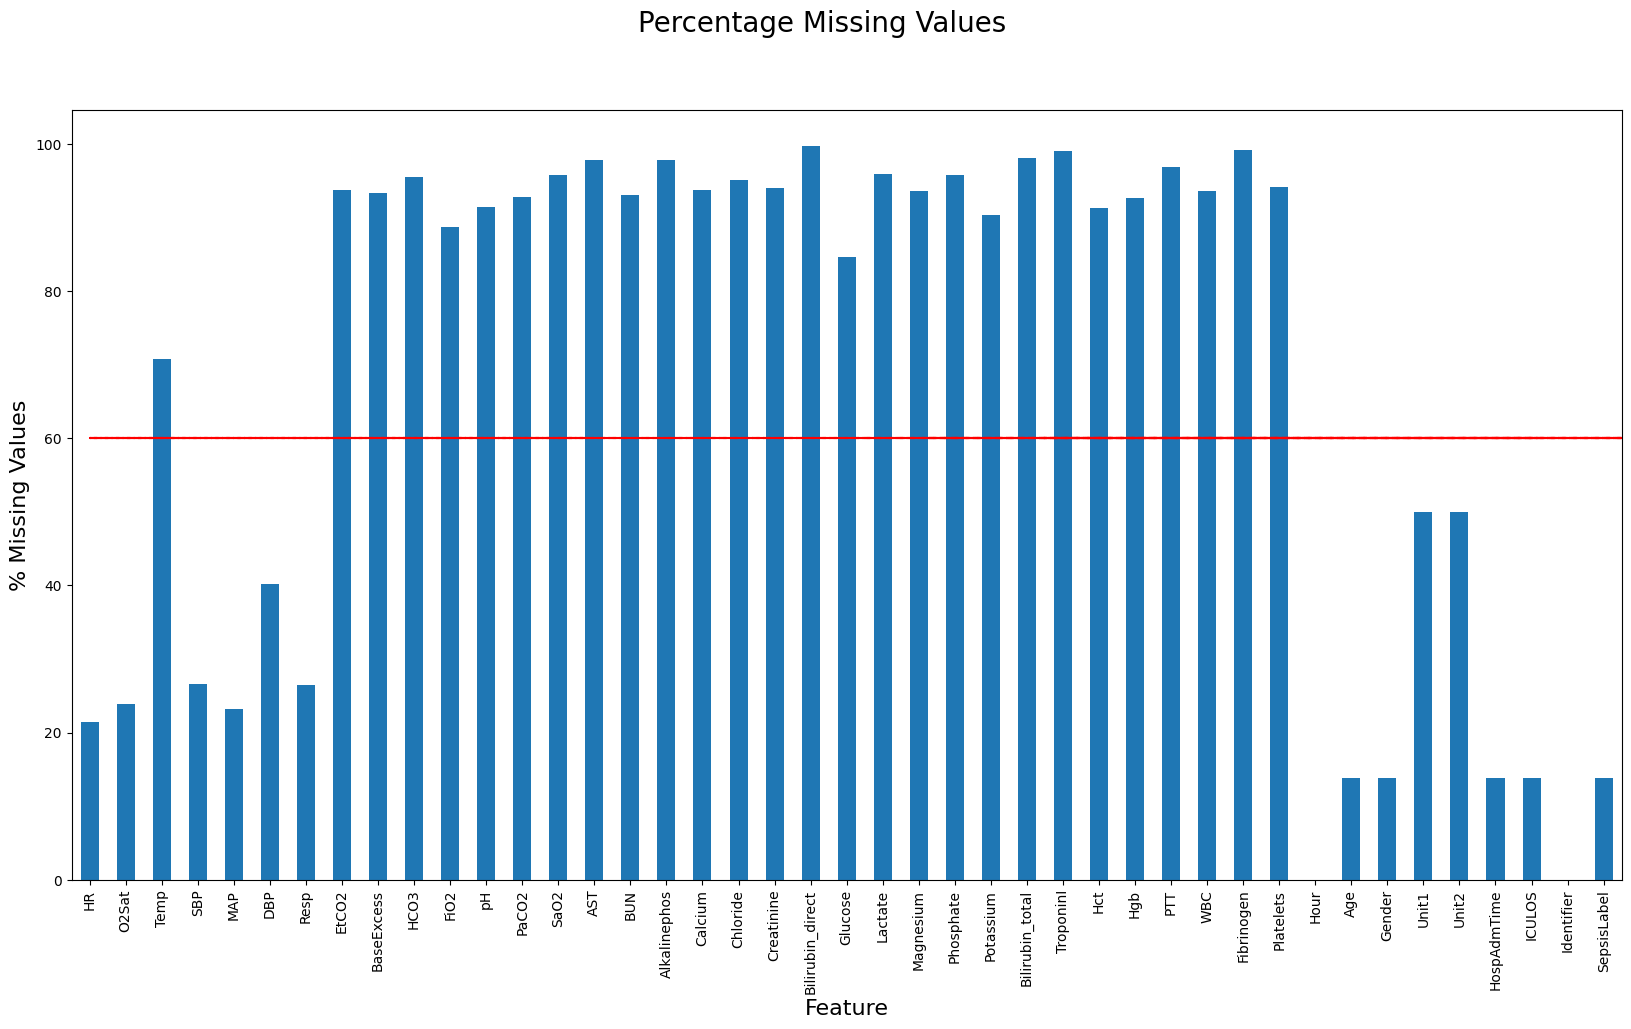

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt

# Set the working directory
os.chdir('/content/drive/My Drive/Colab Notebooks/Physionet_sepsis_project/Data/data_set4')

i = 0
df = pd.DataFrame()

# Loop through all .csv files in the directory
for file in glob.iglob('*.csv'):
    # Extract the filename without extension
    f_name = os.path.splitext(os.path.basename(file))[0]

    # Try to extract a numeric identifier if possible
    try:
        f_name = float(f_name[1:])  # Assuming the first character is not part of the number
    except ValueError:
        f_name = f_name  # If it can't be converted to a float, keep the original string

    # Read the .csv file
    tempdf = pd.read_csv(file, index_col=None, header=0)
    tempdf['Hour'] = tempdf.index
    tempdf['Identifier'] = f_name
    df = pd.concat([df, tempdf], axis=0)
    i = i + 1

# Names of all columns in the data that contain physiological data
physiological_cols = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets']

# Names of all columns in the data that contain demographic data
demographic_cols = ['Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS']

# Columns of features #730
feature_cols = physiological_cols + ['Hour'] + demographic_cols + ['Identifier']

# The name of the column that contains the value we are trying to predict
label_col = 'SepsisLabel'

# Reorganize columns
cols = feature_cols + [label_col]

# Move the SepsisLabel column to the end of the dataframe
df = df.loc[:, cols]

# Plot percentage of missing values (NaNs) for each feature
cutoff = 60
fig = plt.figure(figsize=(20, 10))
percent_missing = (df.isna().sum() / df.shape[0]) * 100
percent_missing.plot(kind="bar")
plt.plot(percent_missing, np.array([cutoff for _ in range(len(percent_missing))]), 'r--')
fig.suptitle('Percentage Missing Values', fontsize=20)
plt.xlabel('Feature', fontsize=16)
plt.ylabel('% Missing Values', fontsize=16)
plt.savefig('histogram.jpg')

# Retain columns in the dataframe with <= cutoff% missing values
df = df.loc[:, df.columns[percent_missing <= cutoff]]
print('Retained features:')
print(df.columns.values)

# Update feature columns
feature_cols = df.columns.values[:-1]

# Adjust physiological and demographic column names
physiological_cols = [x for x in feature_cols if x in set(physiological_cols)]
demographic_cols = [x for x in feature_cols if x in set(demographic_cols)]

# Separate the numeric columns (those suitable for imputation) from the categorical ones
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Apply imputation only on numeric columns
df_filled = pd.DataFrame(data=IterativeImputer().fit_transform(df[numeric_cols]),
                         columns=numeric_cols,
                         index=df.index)

# Add back the non-numeric columns to the dataframe
for col in df.columns:
    if col not in numeric_cols:
        df_filled[col] = df[col]

pd.set_option('display.expand_frame_repr', False)
df_filled['SepsisLabel'] = df['SepsisLabel']
print(df_filled.head())
print("files scanned", i)


<ipython-input-6-110ba42d2478>:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr = corr.replace([np.inf, -np.inf], np.nan)  # Replace infinities with NaN


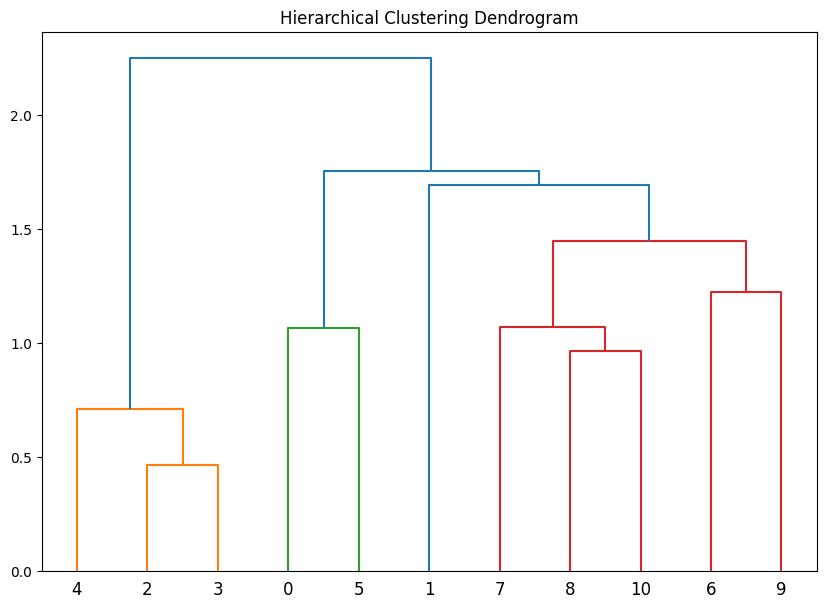

Linkage matrix Z:
[[ 2.          3.          0.46568801  2.        ]
 [ 4.         11.          0.71208335  3.        ]
 [ 8.         10.          0.96617254  2.        ]
 [ 0.          5.          1.06641037  2.        ]
 [ 7.         13.          1.07349934  3.        ]
 [ 6.          9.          1.22576914  2.        ]
 [15.         16.          1.44719069  5.        ]
 [ 1.         17.          1.69598624  6.        ]
 [14.         18.          1.75761158  8.        ]
 [12.         19.          2.25192031 11.        ]]


In [ ]:
import numpy as np
import pandas as pd
from sklearn.impute import IterativeImputer
import scipy.stats as ss
from scipy.cluster.hierarchy import linkage

# Function to clean the correlation matrix by replacing NaN and infinite values with 0
def clean_correlation_matrix(corr):
    corr = corr.replace([np.inf, -np.inf], np.nan)  # Replace infinities with NaN
    corr = corr.fillna(0)  # Replace NaNs with 0
    return corr

# Function to calculate correlation ratio (Continuous vs Ordinal or Binary)
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat) + 1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0, cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array, n_array)) / np.sum(n_array)
    numerator = np.sum(np.multiply(n_array, np.power(np.subtract(y_avg_array, y_total_avg), 2)))
    denominator = np.sum(np.power(np.subtract(measurements, y_total_avg), 2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator / denominator)
    return eta

# Function to calculate Cramer's V (Categorical vs Categorical correlation)
def cramers_phi(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Assume df_filled is already prepared with the imputed data
continuous_cols = list(df_filled[df_filled.columns[0:6]].columns.values)
ordinal_cols = ['Hour', 'Age', 'HospAdmTime', 'ICULOS']
binary_cols = ['Gender']

# Round ordinal and binary columns
df_filled[ordinal_cols] = df_filled[ordinal_cols].round()
df_filled[binary_cols] = df_filled[binary_cols].round()

# Initialize correlation matrix
corr = pd.DataFrame(columns=continuous_cols + ordinal_cols + binary_cols,
                    index=continuous_cols + ordinal_cols + binary_cols)

# Calculate correlation between continuous variables using Pearson's Rho
con_con_corr = df_filled[continuous_cols].corr(method='pearson')
corr[continuous_cols] = con_con_corr

# Calculate correlation ratio for continuous vs binary/ordinal
for con_col_name in continuous_cols:
    for bin_col_name in binary_cols:
        val = correlation_ratio(df_filled[con_col_name].values, df_filled[bin_col_name].values)
        corr.loc[con_col_name, bin_col_name] = val
        corr.loc[bin_col_name, con_col_name] = val
    for ord_col_name in ordinal_cols:
        val = correlation_ratio(df_filled[con_col_name].values, df_filled[ord_col_name].values)
        corr.loc[con_col_name, ord_col_name] = val
        corr.loc[ord_col_name, con_col_name] = val

# Calculate correlation between ordinal & ordinal and binary & binary using Cramer's V
for col in [ordinal_cols, binary_cols]:
    for i in range(0, len(col)):
        for j in range(i, len(col)):
            if i == j:
                corr.loc[col[i], col[j]] = 1.0
            else:
                val = cramers_phi(df_filled[col[i]].values, df_filled[col[j]].values)
                corr.loc[col[i], col[j]] = val
                corr.loc[col[j], col[i]] = val

# Calculate correlation between ordinal & binary variables using Cramer's V
for ord_col_name in ordinal_cols:
    for bin_col_name in binary_cols:
        val = cramers_phi(df_filled[ord_col_name].values, df_filled[bin_col_name].values)
        corr.loc[ord_col_name, bin_col_name] = val
        corr.loc[bin_col_name, ord_col_name] = val

# Clean the correlation matrix before performing clustering
corr = clean_correlation_matrix(corr)

# Generate the linkage matrix for hierarchical clustering
Z = linkage(corr, 'ward')

# To visualize the dendrogram (optional)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

print("Linkage matrix Z:")
print(Z)


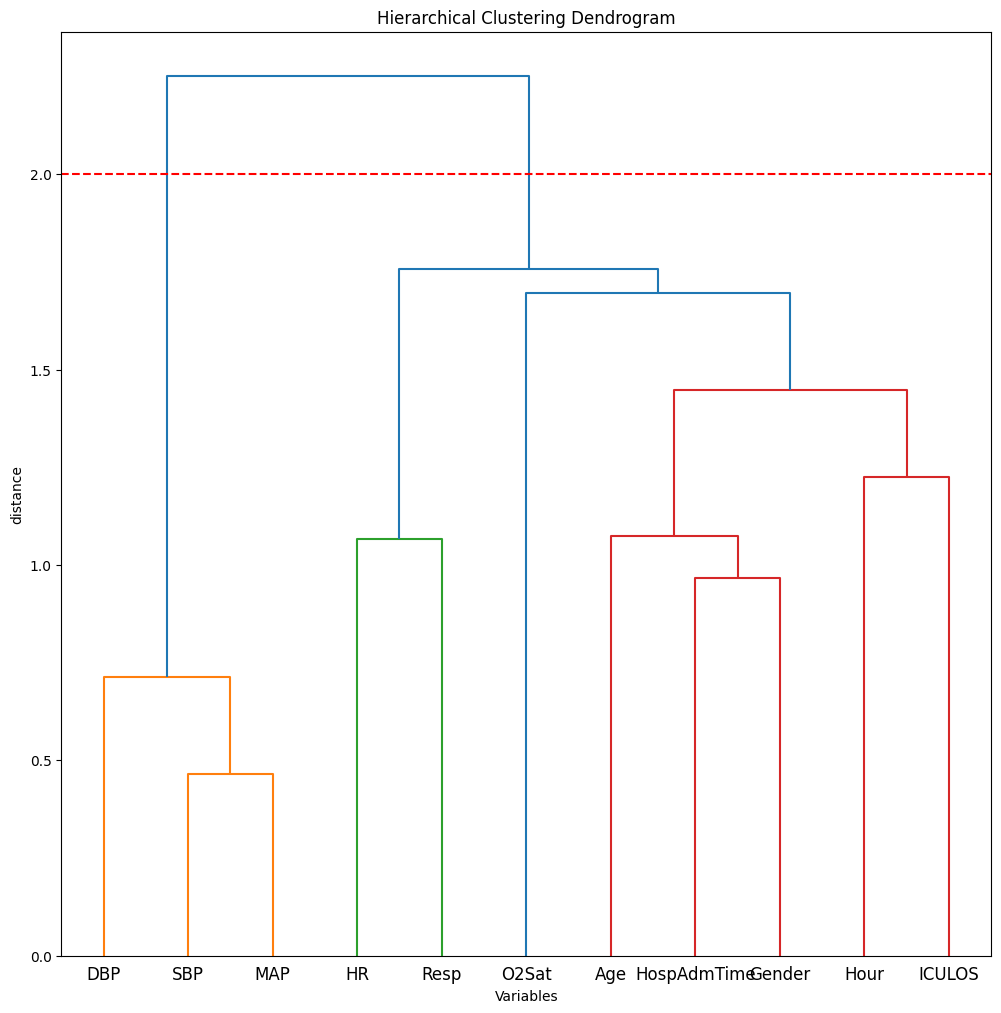

<Figure size 640x480 with 0 Axes>

In [ ]:
# Calculate full dendrogram
plt.figure(figsize=(12, 12))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Variables')
plt.ylabel('distance')
dendrogram(Z, labels=list(corr.columns))
plt.axhline(y=2, color='r', linestyle='--')
plt.show()
plt.savefig('dendogram.jpg')

In [ ]:
# Ensure 'SepsisLabel' column is defined in the DataFrame `df_filled`
# Replace 'SepsisLabel' with the actual column name if it's different
if 'SepsisLabel' in df_filled.columns:
    sepsis = df_filled['SepsisLabel']
else:
    raise KeyError("Column 'SepsisLabel' not found in the dataset.")

# Process the cluster data
pca = PCA(n_components=1)
cluster_data_1 = df_filled[["Hour", "ICULOS"]].values
cluster_data_2 = df_filled[["HospAdmTime", "DBP", "SBP", "MAP"]].values
cluster_data_3 = df_filled[["HR", "Resp", "O2Sat", "Age", "Gender"]].values

cluster_score_1 = pca.fit_transform(StandardScaler().fit_transform(cluster_data_1))
cluster_score_2 = pca.fit_transform(StandardScaler().fit_transform(cluster_data_2))
cluster_score_3 = pca.fit_transform(StandardScaler().fit_transform(cluster_data_3))

# Combine cluster scores into a single feature matrix
x = np.array([cluster_score_1.flatten(), cluster_score_2.flatten(), cluster_score_3.flatten()])
X = x.T

# Define the target variable `y`
y = sepsis.to_numpy()

# Print the shapes to verify
print("X shape:", X.shape)
print("y shape:", y.shape)
print("y type:", type(y))


X shape: (62451, 3)
y shape: (62451,)
y type: <class 'numpy.ndarray'>


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.Regresso

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 17229, number of negative: 17228
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3057
[LightGBM] [Info] Number of data points in the train set: 34457, number of used features: 13
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds
Did not meet ear

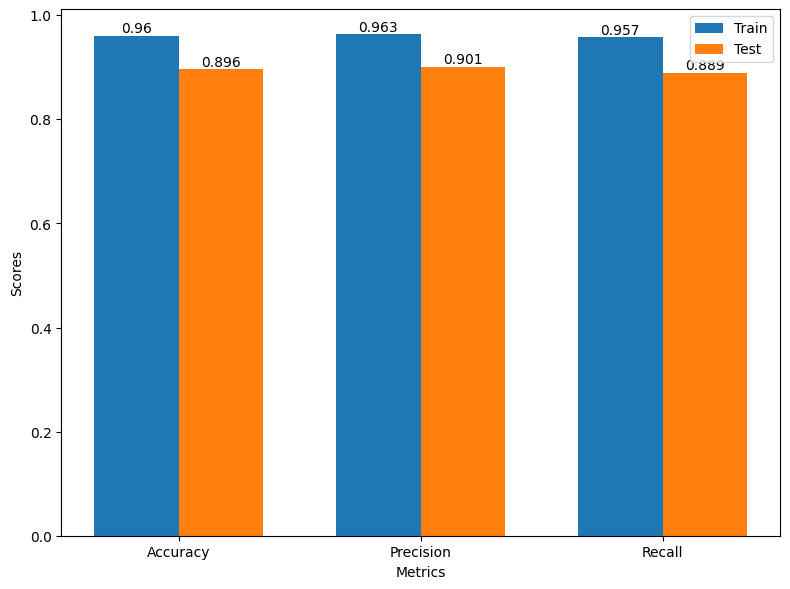

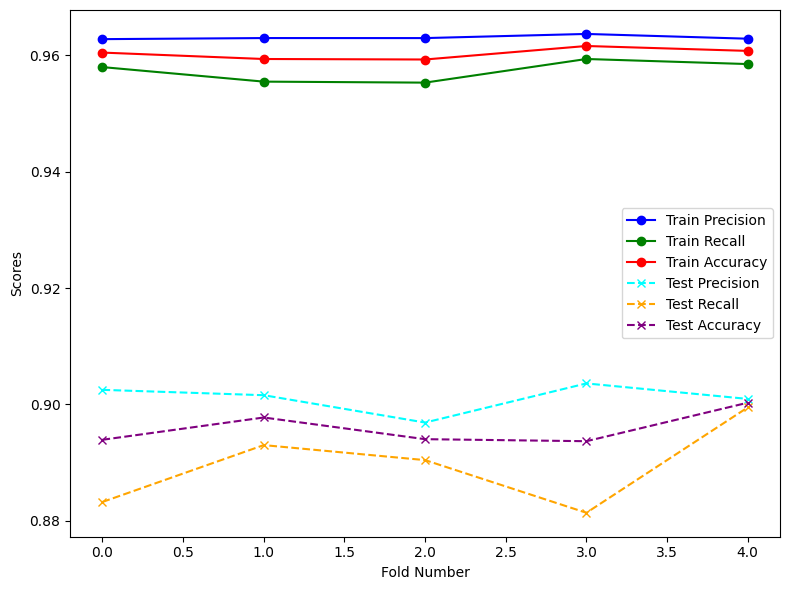

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import matplotlib.pyplot as plt

# Set the working directory
os.chdir('/content/drive/My Drive/Colab Notebooks/Physionet_sepsis_project/Data/data_set4')

# Initialize DataFrame
i = 0
df = pd.DataFrame()

# Read and process all .csv files
for file in glob.iglob('*.csv'):
    f_name = os.path.splitext(os.path.basename(file))[0]
    try:
        f_name = float(f_name[1:])
    except ValueError:
        pass

    tempdf = pd.read_csv(file, index_col=None, header=0)
    tempdf['Hour'] = tempdf.index
    tempdf['Identifier'] = f_name
    df = pd.concat([df, tempdf], axis=0)
    i += 1

# Define feature and label columns
physiological_cols = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp']
demographic_cols = ['Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS']
label_col = 'SepsisLabel'
selected_features = physiological_cols + demographic_cols

cols = selected_features + [label_col]

# Retain only selected columns
df = df.loc[:, cols]

# Imputation and data cleaning
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
imputer = IterativeImputer(max_iter=10, random_state=42)
df_filled = pd.DataFrame(data=imputer.fit_transform(df[numeric_cols]),
                         columns=numeric_cols, index=df.index)
df_filled['SepsisLabel'] = df['SepsisLabel']

# Check for NaN values in target column 'SepsisLabel'
y = df_filled['SepsisLabel']

# Drop rows with NaN values in the target variable
df_filled = df_filled.dropna(subset=['SepsisLabel'])

# Redefine X and y after dropping NaN values
X = df_filled[selected_features]
y = df_filled['SepsisLabel']

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Model training and evaluation
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_precision, train_recall, train_accuracy = [], [], []
test_precision, test_recall, test_accuracy = [], [], []

for train_idx, val_idx in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    clf = lgb.LGBMClassifier(
        objective="binary",
        class_weight="balanced",
        n_estimators=2000,  # Increased number of estimators
        learning_rate=0.005,  # Smaller learning rate for finer adjustments
        max_depth=20,  # Increased depth
        num_leaves=100,  # Adjusted leaf size
        min_data_in_leaf=20,  # Ensure better generalization
        subsample=0.8,  # Prevent overfitting by subsampling
        colsample_bytree=0.8,  # Prevent overfitting by column sampling
        random_state=42
    )

    clf.fit(
        X_train_fold,
        y_train_fold,
        eval_set=[(X_val_fold, y_val_fold)],
        eval_metric="binary_logloss",
        callbacks=[lgb.early_stopping(stopping_rounds=100)]
    )

    y_train_pred = clf.predict(X_train_fold)
    y_val_pred = clf.predict(X_val_fold)

    train_precision.append(precision_score(y_train_fold, y_train_pred))
    train_recall.append(recall_score(y_train_fold, y_train_pred))
    train_accuracy.append(accuracy_score(y_train_fold, y_train_pred))

    test_precision.append(precision_score(y_val_fold, y_val_pred))
    test_recall.append(recall_score(y_val_fold, y_val_pred))
    test_accuracy.append(accuracy_score(y_val_fold, y_val_pred))

# Aggregate results
print(f"Train Precision: {np.mean(train_precision) * 100:.3f}%")
print(f"Train Recall: {np.mean(train_recall) * 100:.3f}%")
print(f"Train Accuracy: {np.mean(train_accuracy) * 100:.3f}%")
print(f"Validation Precision: {np.mean(test_precision) * 100:.3f}%")
print(f"Validation Recall: {np.mean(test_recall) * 100:.3f}%")
print(f"Validation Accuracy: {np.mean(test_accuracy) * 100:.3f}%")

#print(f"Files scanned: {i}")
# Comparison Bar Graph
metrics = ['Accuracy', 'Precision', 'Recall']
train_scores = [np.mean(train_accuracy), np.mean(train_precision), np.mean(train_recall)]
test_scores = [np.mean(test_accuracy), np.mean(test_precision), np.mean(test_recall)]

x = np.arange(len(metrics))  # label locations
width = 0.35  # width of bars

fig, ax = plt.subplots(figsize=(8, 6))

# Plotting the bars for train and test metrics
bars1 = ax.bar(x - width/2, train_scores, width, label='Train')
bars2 = ax.bar(x + width/2, test_scores, width, label='Test')

# Set labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
#ax.set_title('Comparison of Train and Test Scores')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Adding value labels on top of the bars
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 3), va='bottom', ha='center')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()

# Evaluation Metrics Line Graph
fig, ax = plt.subplots(figsize=(8, 6))

# Plotting train and test metrics for precision, recall, and accuracy
ax.plot(range(len(train_precision)), train_precision, label='Train Precision', color='blue', marker='o')
ax.plot(range(len(train_recall)), train_recall, label='Train Recall', color='green', marker='o')
ax.plot(range(len(train_accuracy)), train_accuracy, label='Train Accuracy', color='red', marker='o')

ax.plot(range(len(test_precision)), test_precision, label='Test Precision', color='cyan', linestyle='--', marker='x')
ax.plot(range(len(test_recall)), test_recall, label='Test Recall', color='orange', linestyle='--', marker='x')
ax.plot(range(len(test_accuracy)), test_accuracy, label='Test Accuracy', color='purple', linestyle='--', marker='x')

# Set labels and title
ax.set_xlabel('Fold Number')
ax.set_ylabel('Scores')
#ax.set_title('Evaluation Metrics Across Folds')
ax.legend()

plt.tight_layout()
plt.show()
